In [1]:
import processor
import matplotlib.pyplot as plt
from data import Data, preprocess_midi_files_under
import torch
from model import load_model
import random
from midi_data import get_tokens
import midi_data as md
import json

In [20]:
preprocess_midi_files_under(f'C:/Users/Draco/Documents/GitHub/MusicTransformer-pytorch/dataset/midi_7_composers', 'preprocess_7_composers')

 [C:/Users/Draco/Documents/GitHub/MusicTransformer-pytorch/dataset/midi_7_composers\Bach, Johann Sebastian, 15 Sinfonias, BWV 787-801, ntLGHRX5XOE.mid]

 [C:/Users/Draco/Documents/GitHub/MusicTransformer-pytorch/dataset/midi_7_composers\Bach, Johann Sebastian, Air in F major, BWV Anh.131, ofljU7lmZMA.mid] [C:/Users/Draco/Documents/GitHub/MusicTransformer-pytorch/dataset/midi_7_composers\Bach, Johann Sebastian, Allemande in C minor, BWV 834, 0lx-kPXgPw8.mid] [C:/Users/Draco/Documents/GitHub/MusicTransformer-pytorch/dataset/midi_7_composers\Bach, Johann Sebastian, Allemande in G minor, BWV 836, mCCux8jvhkA.mid] [C:/Users/Draco/Documents/GitHub/MusicTransformer-pytorch/dataset/midi_7_composers\Bach, Johann Sebastian, Als der gu╠êtige Gott vollenden wollt sein Wort, BWV 264, I69tdLLbIyw.mid] [C:/Users/Draco/Documents/GitHub/MusicTransformer-pytorch/dataset/midi_7_composers\Bach, Johann Sebastian, Andante in G minor, BWV 969, IN5Ma07uT5M.mid] [C:/Users/Draco/Documents/GitHub/MusicTransformer-pytorch/dataset/midi_7_composers\Bach, Johann Sebastian, Applicatio in C major, BWV 994, eT0Qcf4C0fI.mid] [C:/Users/Draco/Documents/GitHub/MusicTransfo

In [2]:
# Example usage:
config = processor.load_config(filepath="config/config_thor.yaml")
batch_size = config["batch_size"]
block_size = config["block_size"]
max_iters = config["max_iters"]
eval_interval = config["eval_interval"]
save_interval = config["save_interval"]
learning_rate = config["learning_rate"]
eval_iters = config["eval_iters"]
n_embd = config["n_embd"]
n_head = config["n_head"]
n_layer = config["n_layer"]
dropout = config["dropout"]
vocab_size = config["vocab_size"]
device = config["device"]
generated_event_length = config["generated_event_length"]

In [3]:
train_data, val_data = Data('C:/Users/Draco/Documents/DTU/AI Thing/dataset/preprocess_7_composers').train_test_data()
# data = torch.tensor(get_tokens())

In [4]:
torch.manual_seed(1337)



m = load_model()

def shift_sequence(sequence, rand_ints, lower_bound, upper_bound):
    shifted_sequence = sequence.clone()
    for i in range(sequence.size(0)):
        mask = (sequence[i] >= lower_bound) & (sequence[i] < upper_bound)
        shifted_sequence[i, mask] = torch.clamp(sequence[i, mask] + rand_ints[i], min=lower_bound, max=upper_bound - 1)
    return shifted_sequence

def multiply_sequence(sequence, rand_ints, lower_bound, upper_bound):
    multiplied_sequence = sequence.clone()
    for i in range(sequence.size(0)):
        mask = (sequence[i] >= lower_bound) & (sequence[i] < upper_bound)
        multiplied_sequence[i, mask] = torch.clamp((sequence[i, mask] - lower_bound) * rand_ints[i] + lower_bound, min=lower_bound, max=upper_bound - 1)
    return multiplied_sequence

# Data loading with metadata integration
def get_batch(split):
    # Select train or validation data
    data = train_data if split == 'train' else val_data
    batch_sequences = random.sample(data, batch_size)
    
    # Separate sequences and metadata
    sequences = [item[0] for item in batch_sequences]
    metadata = {"composer": torch.tensor([item[1]["composer"] for item in batch_sequences])}

    # Generate random starting indices for each sequence in the batch
    ix = [random.randint(0, len(seq) - block_size - 1) for seq in sequences]

    # Process sequences for input (x) and target (y)
    new_x = torch.stack([torch.tensor(seq[ix[i]:ix[i] + block_size]) for i, seq in enumerate(sequences)])
    new_y = torch.stack([torch.tensor(seq[ix[i] + 1:ix[i] + block_size + 1]) for i, seq in enumerate(sequences)])

    # Pitch shifting
    note_r_ints = [random.randint(-12, 12) for _ in range(batch_size)]
    note_lb = processor.START_IDX["notes"]
    note_ub = processor.START_IDX["notes"] + processor.RANGE_NOTES
    new_x = shift_sequence(new_x, note_r_ints, note_lb, note_ub)
    new_y = shift_sequence(new_y, note_r_ints, note_lb, note_ub)
    
    # Velocity shifting
    vel_r_ints = [random.randint(-20, 20) for _ in range(batch_size)]
    vel_lb = processor.START_IDX["velocity"]
    vel_ub = processor.START_IDX["velocity"] + processor.RANGE_VEL
    new_x = shift_sequence(new_x, vel_r_ints, vel_lb, vel_ub)
    new_y = shift_sequence(new_y, vel_r_ints, vel_lb, vel_ub)
    
    # Time multiplication
    time_r_ints = [max(1, random.randint(1, 8) // 2) for _ in range(batch_size)]
    time_lb = processor.START_IDX["time_shift"]
    time_ub = processor.START_IDX["time_shift"] + processor.RANGE_TIME_SHIFT
    new_x = multiply_sequence(new_x, time_r_ints, time_lb, time_ub)
    new_y = multiply_sequence(new_y, time_r_ints, time_lb, time_ub)
    
    # Length multiplication
    len_lb = processor.START_IDX["length"]
    len_ub = processor.START_IDX["length"] + processor.RANGE_LEN
    new_x = multiply_sequence(new_x, time_r_ints, len_lb, len_ub)
    new_y = multiply_sequence(new_y, time_r_ints, len_lb, len_ub)
    
    return new_x.to(device), new_y.to(device), {k: v.to(device) for k, v in metadata.items()}

@torch.no_grad()
def estimate_loss_and_accuracy():
    out = {}
    accuracies = {}
    m.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        accuracies_split = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y, metadata = get_batch(split)
            logits, loss = m(X, metadata, Y)  # Pass metadata to the model
            losses[k] = loss.item()
            accuracies_split[k] = calculate_accuracy(logits, Y)  # Calculate accuracy
        out[split] = losses.mean()
        accuracies[split] = accuracies_split.mean()
    m.train()
    return out, accuracies

def calculate_accuracy(logits, targets):
    """
    Calculates accuracy for the given logits and target values.
    Args:
        logits (torch.Tensor): Model outputs of shape (batch_size, sequence_length, vocab_size).
        targets (torch.Tensor): Ground truth labels of shape (batch_size, sequence_length).
    Returns:
        float: Accuracy as a percentage.
    """
    predictions = torch.argmax(logits, dim=-1)  # Get predicted indices
    correct = (predictions == targets).float()  # Compare predictions with targets
    accuracy = correct.sum() / correct.numel()  # Calculate accuracy
    return accuracy.item() * 100



# Print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()) / 1e6, 'M parameters')

# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
eval_steps = []

# Training loop
for iter in range(max_iters):
    if iter % config['save_interval'] == config['save_interval'] - 1:
        torch.save(m.state_dict(), f'models/train_{losses["train"]:.4f}-val_{losses["val"]:.4f}.pth')

    # Evaluate the loss and accuracy on train and val sets at intervals
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses, accuracies = estimate_loss_and_accuracy()
        
        # Log metrics
        eval_steps.append(iter)
        train_losses.append(losses['train'].item())
        val_losses.append(losses['val'].item())
        train_accuracies.append(accuracies['train'])
        val_accuracies.append(accuracies['val'])
        
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, "
              f"train acc {accuracies['train']:.2f}%, val acc {accuracies['val']:.2f}%")

    # Sample a batch of data
    xb, yb, metadata = get_batch('train')

    # Evaluate the loss
    logits, loss = m(xb, metadata, yb)  # Pass metadata to the model
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

6.579589 M parameters
step 0: train loss 6.1556, val loss 6.1538, train acc 0.25%, val acc 0.24%
step 100: train loss 3.6718, val loss 3.7130, train acc 15.49%, val acc 14.47%
step 200: train loss 3.5228, val loss 3.5710, train acc 17.08%, val acc 15.82%
step 300: train loss 3.4025, val loss 3.4634, train acc 18.16%, val acc 16.87%
step 400: train loss 3.3114, val loss 3.3803, train acc 19.04%, val acc 17.49%
step 500: train loss 3.2031, val loss 3.2552, train acc 19.52%, val acc 18.21%
step 600: train loss 3.1574, val loss 3.1936, train acc 20.34%, val acc 19.51%
step 700: train loss 3.0916, val loss 3.1198, train acc 21.20%, val acc 20.51%
step 800: train loss 3.0409, val loss 3.0665, train acc 21.93%, val acc 21.16%
step 900: train loss 3.0285, val loss 3.0449, train acc 22.18%, val acc 21.68%
step 1000: train loss 2.9910, val loss 3.0231, train acc 22.94%, val acc 21.96%
step 1100: train loss 2.9511, val loss 3.0042, train acc 23.33%, val acc 22.10%
step 1200: train loss 2.9341, va

KeyboardInterrupt: 

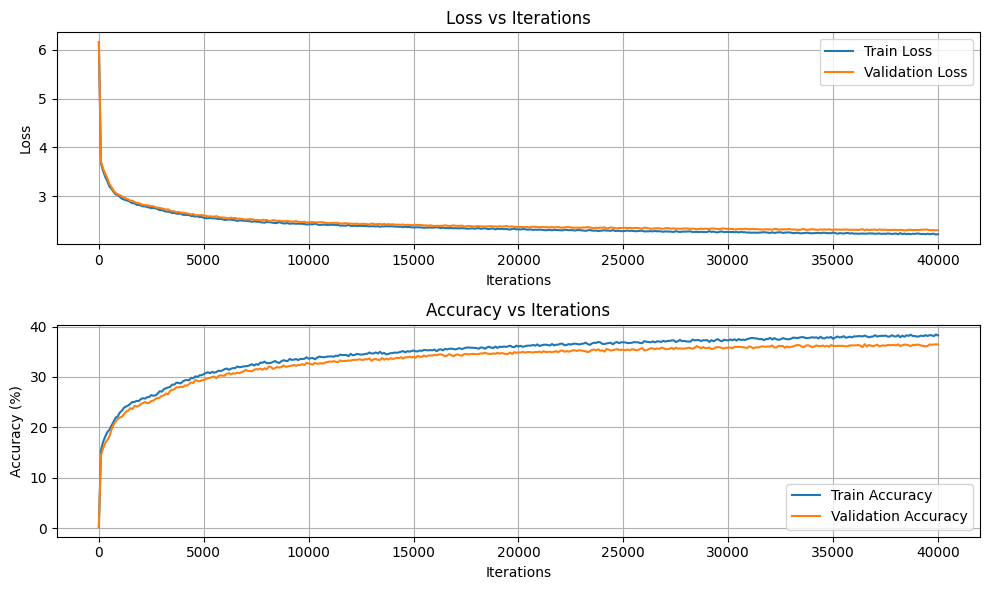

In [6]:
# Plot the metrics
plt.figure(figsize=(10, 6))

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(eval_steps, train_losses, label='Train Loss')
plt.plot(eval_steps, val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.legend()
plt.grid()

# Accuracy plot
plt.subplot(2, 1, 2)
plt.plot(eval_steps, train_accuracies, label='Train Accuracy')
plt.plot(eval_steps, val_accuracies, label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Iterations')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [11]:
X, Y, metadata = get_batch('train') 
logits, loss = m(X, metadata, Y)  # Pass metadata to the model

In [13]:
X.shape

torch.Size([16, 256])

In [10]:
torch.save(m.state_dict(), f'models/train_{losses["train"]:.4f}-val_{losses["val"]:.4f}.pth')
# m = load_model('models/train_2.6325-val_3.1961.pth')

In [7]:
# Set the composer metadata
composers = ['Bach', 'Beethoven', 'Chopin', 'Liszt', 'Mozart', 'Scarlatti', 'Schubert']
composer_name = "Bach"  # Choose the composer you want
composer_index = composers.index(composer_name)

# Prepare metadata input with the specified composer
metadata = {
    "composer": torch.tensor([composer_index]).to(device)  # Metadata for a batch of 1
}
# generate from the model
context = torch.tensor([[32, 44, 56]], device=device)
with torch.no_grad():
    generated_sequence = m.generate(context, metadata, 200).tolist()

In [8]:
processor.decode_midi(generated_sequence[0], 'thing.mid')